In [560]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict 
import random
import time
import math
import sys

In [512]:
# Preprocessing 
data = pd.read_table("BIOGRID-ORGANISM-Zea_mays-3.5.182.tab2.txt", low_memory = False)
# Extract interactions
val = data.copy()
val.set_index("Experimental System Type", inplace = True)
val = val.filter(items = ["Official Symbol Interactor A", "Official Symbol Interactor B", "Pubmed ID"])
val = val.filter(like = "genetic", axis = 0)
# graph = nx.from_pandas_edgelist(val, "Official Symbol Interactor A", "Official Symbol Interactor B", create_using=nx.DiGraph)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [561]:
# Helper functions
def subgraphs_n(graph):
    subgraphs = list(nx.weakly_connected_component_subgraphs(graph))
    subgraphs_n = defaultdict(list)
    for subgraph in subgraphs:
        subgraphs_n[nx.number_of_nodes(subgraph)].append(subgraph)
    return subgraphs_n

def attributes(x):
    """
    Returns [number of source nodes, number of outgoing edges per node...]
    which is equivalent to d(x, 0) for connectivity matrix x
    
    x is a pandas dataframe
    """
    n = len(x)
    
    # Initialize with counter of source nodes
    result = [0]
    
    # Increment counter for number of source nodes
    for j in range(n):
        for i in range(n):
            if x.iloc[i,j] != 0:
                break
            elif i == n - 1:
                result[0] += 1
    result[0] = str(result[0])
    # Append sorted list of number of outgoing edges per node
    result.extend(sorted([str(int(sum(x.iloc[i]))) for i in range(n)]))
    result_string = "".join(result)
    return result_string

def subgraph_hash(subgraphs_n, n, r):
    """
    n is size of subgraph
    r is measurement of similarity (in paper)
    """
    start_time = time.time()
    random.seed(24)
    positions = sorted(random.sample(range(n + 1), n + 1 - r))
#     print(positions)
    table = defaultdict(list)
    for subgraph in subgraphs_n[n]:
        characteristics = attributes(nx.to_pandas_adjacency(subgraph))
        hash_key = []
        for p in positions:
            hash_key.append(characteristics[p])
        hash_key_string = "".join(hash_key)
        table[hash_key_string].append(subgraph)
    print(str(n) + ": " + str(time.time() - start_time))
    print(sys.getsizeof(table))
def total_hash(graph, n, r):
    sgn = subgraphs_n(graph)
    print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    subgraph_hash(sgn, n, r)
#     print(table)    

In [562]:
def subgraphs_n_uniform(graph):
    subgraphs = list(nx.weakly_connected_component_subgraphs(graph))
    subgraphs_n = defaultdict(list)
    for subgraph in subgraphs:
        subgraphs_n[nx.number_of_nodes(subgraph)].append(subgraph)
    count = min(len(subgraphs_n[3]), len(subgraphs_n[4]), len(subgraphs_n[5]), len(subgraphs_n[6]))
    for i in range(3, 7):
        subgraphs_n[i] = random.sample(subgraphs_n[i], count)
    return subgraphs_n
def total_hash_uniform(graph, n, r):
    sgn = subgraphs_n_uniform(graph)
    print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    subgraph_hash(sgn, n, r)

In [563]:
random.seed(24)
graph_1 = nx.fast_gnp_random_graph(100000, 0.000003, seed=24, directed=True)
# Size of motif + Size of Network
for n in range(3, 7):
    total_hash_uniform(graph_1, n, int(math.ceil(n*1.0/2)))

395 395 395 395
3: 0.5215308666229248
248
395 395 395 395
4: 0.5757877826690674
248
395 395 395 395
5: 0.6850306987762451
248
395 395 395 395
6: 0.8390793800354004
248


In [564]:
graph_3 = nx.fast_gnp_random_graph(1000000, 0.00000035, seed=24, directed=True)
# print(sorted(subgraphs_n(graph).keys()))
# sgn = subgraphs_n(graph)
# print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
for n in range(3, 7):
    total_hash_uniform(graph_3, n, int(math.ceil(n*1.0/2)))

4514 4514 4514 4514
3: 5.992841005325317
248
4514 4514 4514 4514
4: 7.133245944976807
248
4514 4514 4514 4514
5: 7.574980974197388
248
4514 4514 4514 4514
6: 9.136425971984863
376


In [566]:
graph_2 = nx.fast_gnp_random_graph(500000, 0.0000004, seed=24, directed=True)
# print(sorted(subgraphs_n(graph).keys()))
# sgn = subgraphs_n_uniform(graph)
# print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
for n in range(3, 7):
    total_hash_uniform(graph_2, n, int(math.ceil(n*1.0/2)))

824 824 824 824
3: 1.1256887912750244
248
824 824 824 824
4: 1.2708778381347656
248
824 824 824 824
5: 1.3618290424346924
248
824 824 824 824
6: 1.7881159782409668
248


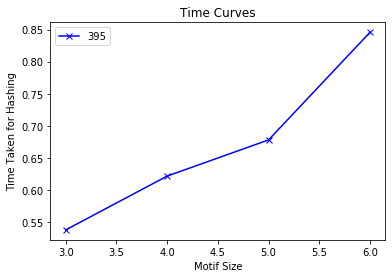

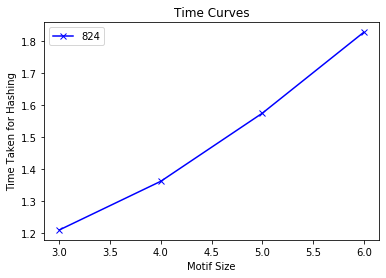

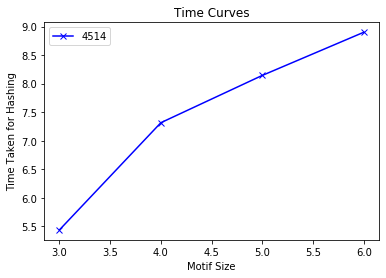

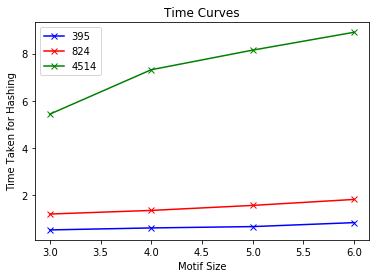

In [569]:
import matplotlib.pyplot as plt
def time_curve(times, sizes):            
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    plt.figure()
    for i in range(len(sizes)):
        plt.plot([3, 4, 5, 6], times[i], colors[i], marker = "x")
    plt.title("Time Curves")
    plt.xlabel("Motif Size")
    plt.ylabel("Time Taken for Hashing")
    plt.legend(sizes, loc="upper left")
    plt.show()
time_curve([[0.5374, 0.6214, 0.6779, 0.8459]], [395])
time_curve([[1.2100, 1.3620, 1.5745, 1.8273]], [824])
time_curve([[5.4358, 7.3154, 8.1447, 8.9011]], [4514])
time_curve([[0.5374, 0.6214, 0.6779, 0.8459], [1.2100, 1.3620, 1.5745, 1.8273], [5.4358, 7.3154, 8.1447, 8.9011]], [395, 824, 4514])

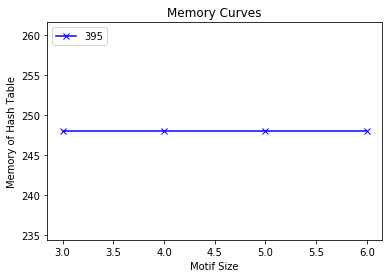

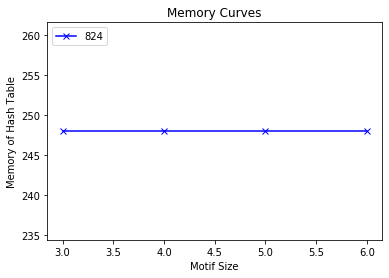

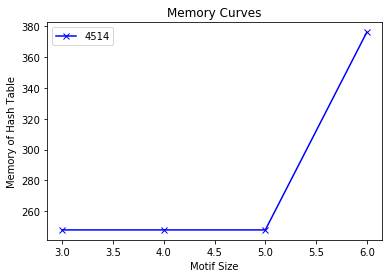

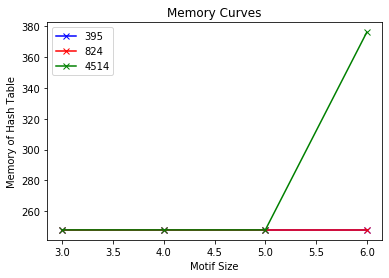

In [570]:
def memory_curve(mems, sizes):            
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    plt.figure()
    for i in range(len(sizes)):
        plt.plot([3, 4, 5, 6], mems[i], colors[i], marker = "x")
    plt.title("Memory Curves")
    plt.xlabel("Motif Size")
    plt.ylabel("Memory of Hash Table")
    plt.legend(sizes, loc="upper left")
    plt.show()
memory_curve([[248, 248, 248, 248]], [395])
memory_curve([[248, 248, 248, 248]], [824])
memory_curve([[248, 248, 248, 376]], [4514])
memory_curve([[248, 248, 248, 248], [248, 248, 248, 248], [248, 248, 248, 376]], [395, 824, 4514])

The problem for future consideration is, then, a matter of applying a randomized sampling method to the operation of processing each subgraph for characteristic extraction. One option would be, instead of summing all rows and then sorting into ascending order, to sum only a subset of the rows and sort these into ascending order, though presumably the time gained by sampling here would be analogous to the time gained in the present algorithm. Or perhaps only a randomly sampled subset of the nodes involved would be considered in the connectivity matrix and subsequent hash, which might result in a slightly better speedup.

Future work should experiment with the creation of other distance metrics, which specifically should require less processing from the basic data structure which stores the subgraph information. By altering this distance metric cleverly, it may be possible to reduce the processing time required without introducing random sampling, and LSH may be more effective in providing a speedup while determining similarities between network motifs.




In [571]:
# Better Distance Function
# NGL IDK HOW TO CHANGE THIS 
def attributes_improved(x):
    """
    Returns [number of source nodes, number of outgoing edges per node...]
    which is equivalent to d(x, 0) for connectivity matrix x
    
    x is a pandas dataframe
    """
    n = len(x)
    
    # Initialize with counter of source nodes
    result = [0]
    
    # Increment counter for number of source nodes
    for j in range(n):
        for i in range(n):
            if x.iloc[i,j] != 0:
                break
            elif i == n - 1:
                result[0] += 1
    result[0] = str(result[0])
    # Append sorted list of number of outgoing edges per node
    result.extend(sorted([str(int(sum(x.iloc[i]))) for i in range(n)]))
    result_string = "".join(result)
    return result_string

# Uses attributes_improved instead
def subgraph_hash_improved(subgraphs_n, n, r):
    """
    n is size of subgraph
    r is measurement of similarity (in paper)
    """
    start_time = time.time()
    random.seed(24)
    positions = sorted(random.sample(range(n + 1), n + 1 - r))
#     print(positions)
    table = defaultdict(list)
    for subgraph in subgraphs_n[n]:
        characteristics = attributes_improved(nx.to_pandas_adjacency(subgraph))
        hash_key = []
        for p in positions:
            hash_key.append(characteristics[p])
        hash_key_string = "".join(hash_key)
        table[hash_key_string].append(subgraph)
    print(str(n) + ": " + str(time.time() - start_time))
    print(sys.getsizeof(table))
    
# Uses subgraph_hash_improved instead    
def total_hash_uniform_improved(graph, n, r):
    sgn = subgraphs_n_uniform(graph)
    print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    subgraph_hash_improved(sgn, n, r)

In [572]:
graph_1 = nx.fast_gnp_random_graph(100000, 0.000003, seed=24, directed=True)
graph_3 = nx.fast_gnp_random_graph(1000000, 0.00000035, seed=24, directed=True)
graph_2 = nx.fast_gnp_random_graph(500000, 0.0000004, seed=24, directed=True)
for n in range(3, 7):
    total_hash_uniform_improved(graph_2, n, int(math.ceil(n*1.0/2)))

824 824 824 824
3: 1.1406357288360596
248
824 824 824 824
4: 1.2556853294372559
248
824 824 824 824
5: 1.4479517936706543
248
824 824 824 824
6: 1.6135149002075195
248
